In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score

PREFERRED = "Preferred Semantics - Highest cardinality"
GROUNDED = "Grounded Semantics - Highest cardinality"
CATEGORISER = "Categoriser - Highest cardinality"

In [30]:
def int_to_float(df):
    for col in df.columns:
        # Check if the column type is int64
        if df[col].dtype == 'int64':
            # Convert to float64
            df[col] = df[col].astype('float64')

In [31]:
def round_values(df):
    def replace_values(x):

        if np.isnan(x):
            return x

        # If number is not integer, than it is undecided
        if isinstance(x, float) and not x.is_integer():
            return np.nan
        
        return x
    
    df[PREFERRED] = df[PREFERRED].apply(replace_values)
    df[GROUNDED] = df[GROUNDED].apply(replace_values)
    df[CATEGORISER] = df[CATEGORISER].apply(replace_values)

In [32]:
def performance_stats(df, results):

    target = "GroundTruth"

    for col in df.columns:
        if col in ["ID", target]:
            continue
        
        # Undecided cases do no enter in the statistics
        filtered_df = df.dropna(subset=[target, col])

        # Calculate Kappa score
        kappa = cohen_kappa_score(filtered_df[target], filtered_df[col])

        # Calculate percentage of NAs
        percent_na = 1 - len(filtered_df)/len(df)

        results["Kcohen"].append(kappa)
        results["Percent NA"].append(percent_na)
        
        # Display the metrics
        # print(f"\n{col}")
        # print(f"Precision: {precision}")
        # print(f"Recall: {recall}")
        # print(f"Youden's Index: {youden_index}")
        # print(f"Accuracy: {accuracy}")
        # print(f"Percent NA: {percent_na:.2f}")

In [33]:
def percent_nas(df):
    nan_count = df.isna().sum()

    # Calculate the total number of entries in each column
    total_count = len(df)

    # Calculate the percentage of NaN values in each column
    nan_percentage = (nan_count / total_count) * 100

    # Display the percentage of NaN values
    print("\nPercentage of NaN values in each column:")
    print(nan_percentage)

In [34]:
def unique_values(df, display = False):
    # Initialize a dictionary to store unique values for each column
    unique_values_dict = {}

    # Iterate through each column in the DataFrame
    for col in df.columns:
        if col == "ID":
            continue
        unique_values_dict[col] = df[col].unique()

    if not display:
        return
    
    # Display the unique values for each column
    for col, unique_values in unique_values_dict.items():
        print(f"Unique values in column '{col}': {unique_values}")

In [35]:
def rulex_results(dataset, conditions, error):

    results = {"Kcohen": [], "Percent NA": []}

    rulex_df = pd.read_csv("./rulex_performance.csv")
    rulex_df['Base'] = rulex_df['Base'].str.strip()
    rulex_df['Conditions'] = rulex_df['Conditions'].astype(str).str.strip()
    rulex_df['Error'] = rulex_df['Error'].astype(str).str.strip()

    for e in error:

        filtered_df = rulex_df[(rulex_df['Base'] == dataset) & (rulex_df['Conditions'] == conditions) & (rulex_df['Error'] == e)]
        for index, row in filtered_df.iterrows():
            # # Repetition. Can be necessary to compare the same result with multiple others
            # for _ in range(4):
            results["Kcohen"].append(row['Kcohen'])
            results["Percent NA"].append(row['Nas'])

    results_df = pd.DataFrame(results, index=["05_error_rulex", "10_error_rulex", "15_error_rulex", "20_error_rulex"])
    return results_df

In [36]:
def get_results_df(all_data):
    results_dict = {"Kcohen":[], "Percent NA": []}

    for df in all_data:
        performance_stats(df, results_dict)

    bases =  ['05_error', '10_error', '15_error', '20_error']
    budgets = ['25_budget', '50_budget', '90_budget', '100_budget']
    semantics = ['preferred', 'categoriser', 'grounded']
    row_names = []

    for budget in budgets:
        for base in bases:
            for semantic in semantics:
                row_names.append(budget + "_" + base + "_" + semantic)
    
    results_df = pd.DataFrame(results_dict, index=row_names)

    order = []
    for semantic in semantics:
        for base in bases:
            for budget in budgets:
                order.append(budget + "_" + base + "_" + semantic)
    
    return results_df.loc[order]

In [37]:
base = 'myocardial'
# base = 'cars'
# base = 'genetic'
# base = 'cirrhosis'

# conditions = '4'
# conditions = 'unlimited'
# conditions = '4_score_conditions'

root_folder = base.capitalize() + '/results_framework/'

budgets = ['25_budget', '50_budget', '90_budget', '100_budget']
#budgets = ['25_budget']

all_data = []

for budget in budgets:
    # for error in ["0050", "0100", "0150", "0200"]:
    for error in ["0010", "0040", "0070", "0100"]:  # myocardial errors
    #for error in ["10"]:
        df = pd.read_csv(root_folder + budget + "/" + base + "_multiclass_error_" + error + "_" + budget.split("_")[0] + ".csv", na_values='NaN')
        # print(root_folder + budget + "/" + base + "_score_base_" + error + "_rebuttal_" + budget.split("_")[0] + ".csv")
        # df.to_csv('output_teste_export_' + error + '.csv', index=True)
        int_to_float(df)
        round_values(df)
        unique_values(df)
        all_data.append(df)
        #df.to_csv('output_teste_' + error + '.csv', index=True)

results_df = get_results_df(all_data)

results_df = pd.concat([results_df, rulex_results(base, "unlimited", ["1", "4", "7", "10"])])


# index={'25_budget_05_error_preferred': 'AP1',
#        '50_budget_05_error_preferred': 'AP2',
#        '90_budget_05_error_preferred': 'AP3', 
#        '100_budget_05_error_preferred': 'AP4',
#        '25_budget_10_error_preferred': 'AP5',
#        '50_budget_10_error_preferred': 'AP6',
#        '90_budget_10_error_preferred': 'AP7', 
#        '100_budget_10_error_preferred': 'AP8',
#        '25_budget_15_error_preferred': 'AP9',
#        '50_budget_15_error_preferred': 'AP10',
#        '90_budget_15_error_preferred': 'AP11', 
#        '100_budget_15_error_preferred': 'AP12',
#        '25_budget_20_error_preferred': 'AP13',
#        '50_budget_20_error_preferred': 'AP14',
#        '90_budget_20_error_preferred': 'AP15', 
#        '100_budget_20_error_preferred': 'AP16',
#        '25_budget_05_error_categoriser': 'AC1',
#        '50_budget_05_error_categoriser': 'AC2',
#        '90_budget_05_error_categoriser': 'AC3', 
#        '100_budget_05_error_categoriser': 'AC4',
#        '25_budget_10_error_categoriser': 'AC5',
#        '50_budget_10_error_categoriser': 'AC6',
#        '90_budget_10_error_categoriser': 'AC7', 
#        '100_budget_10_error_categoriser': 'AC8',
#        '25_budget_15_error_categoriser': 'AC9',
#        '50_budget_15_error_categoriser': 'AC10',
#        '90_budget_15_error_categoriser': 'AC11', 
#        '100_budget_15_error_categoriser': 'AC12',
#        '25_budget_20_error_categoriser': 'AC13',
#        '50_budget_20_error_categoriser': 'AC14',
#        '90_budget_20_error_categoriser': 'AC15', 
#        '100_budget_20_error_categoriser': 'AC16',
#        '25_budget_05_error_grounded': 'AG1',
#        '50_budget_05_error_grounded': 'AG2',
#        '90_budget_05_error_grounded': 'AG3', 
#        '100_budget_05_error_grounded': 'AG4',
#        '25_budget_10_error_grounded': 'AG5',
#        '50_budget_10_error_grounded': 'AG6',
#        '90_budget_10_error_grounded': 'AG7', 
#        '100_budget_10_error_grounded': 'AG8',
#        '25_budget_15_error_grounded': 'AG9',
#        '50_budget_15_error_grounded': 'AG10',
#        '90_budget_15_error_grounded': 'AG11', 
#        '100_budget_15_error_grounded': 'AG12',
#        '25_budget_20_error_grounded': 'AG13',
#        '50_budget_20_error_grounded': 'AG14',
#        '90_budget_20_error_grounded': 'AG15', 
#        '100_budget_20_error_grounded': 'AG16',
#        '05_error_rulex': 'H1',
#        '10_error_rulex': 'H2',
#        '15_error_rulex': 'H3',
#        '20_error_rulex': 'H4'
#        }

index={'25_budget_01_error_preferred': 'AP1',
       '50_budget_01_error_preferred': 'AP2',
       '90_budget_01_error_preferred': 'AP3', 
       '100_budget_01_error_preferred': 'AP4',
       '25_budget_04_error_preferred': 'AP5',
       '50_budget_04_error_preferred': 'AP6',
       '90_budget_04_error_preferred': 'AP7', 
       '100_budget_04_error_preferred': 'AP8',
       '25_budget_07_error_preferred': 'AP9',
       '50_budget_07_error_preferred': 'AP10',
       '90_budget_07_error_preferred': 'AP11', 
       '100_budget_07_error_preferred': 'AP12',
       '25_budget_10_error_preferred': 'AP13',
       '50_budget_10_error_preferred': 'AP14',
       '90_budget_10_error_preferred': 'AP15', 
       '100_budget_10_error_preferred': 'AP16',
       '25_budget_01_error_categoriser': 'AC1',
       '50_budget_01_error_categoriser': 'AC2',
       '90_budget_01_error_categoriser': 'AC3', 
       '100_budget_01_error_categoriser': 'AC4',
       '25_budget_04_error_categoriser': 'AC5',
       '50_budget_04_error_categoriser': 'AC6',
       '90_budget_04_error_categoriser': 'AC7', 
       '100_budget_04_error_categoriser': 'AC8',
       '25_budget_07_error_categoriser': 'AC9',
       '50_budget_07_error_categoriser': 'AC10',
       '90_budget_07_error_categoriser': 'AC11', 
       '100_budget_07_error_categoriser': 'AC12',
       '25_budget_10_error_categoriser': 'AC13',
       '50_budget_10_error_categoriser': 'AC14',
       '90_budget_10_error_categoriser': 'AC15', 
       '100_budget_10_error_categoriser': 'AC16',
       '25_budget_01_error_grounded': 'AG1',
       '50_budget_01_error_grounded': 'AG2',
       '90_budget_01_error_grounded': 'AG3', 
       '100_budget_01_error_grounded': 'AG4',
       '25_budget_04_error_grounded': 'AG5',
       '50_budget_04_error_grounded': 'AG6',
       '90_budget_04_error_grounded': 'AG7', 
       '100_budget_04_error_grounded': 'AG8',
       '25_budget_07_error_grounded': 'AG9',
       '50_budget_07_error_grounded': 'AG10',
       '90_budget_07_error_grounded': 'AG11', 
       '100_budget_07_error_grounded': 'AG12',
       '25_budget_10_error_grounded': 'AG13',
       '50_budget_10_error_grounded': 'AG14',
       '90_budget_10_error_grounded': 'AG15', 
       '100_budget_10_error_grounded': 'AG16',
       '01_error_rulex': 'H1',
       '04_error_rulex': 'H2',
       '07_error_rulex': 'H3',
       '10_error_rulex': 'H4'
       }

results_df.rename(index=index, inplace=True)


results_df.to_csv('output.csv', index=True)
results_df

,Kcohen,Percent NA
AP1,0.554251,0.203008
AP2,0.519383,0.002506
AP3,0.606479,0.253133
AP4,0.588407,0.280702
AP5,0.383545,0.223058
AP6,0.369606,0.002506
AP7,0.448641,0.333333
AP8,0.438761,0.338346
AP9,0.406695,0.170426
AP10,0.371440,0.000000


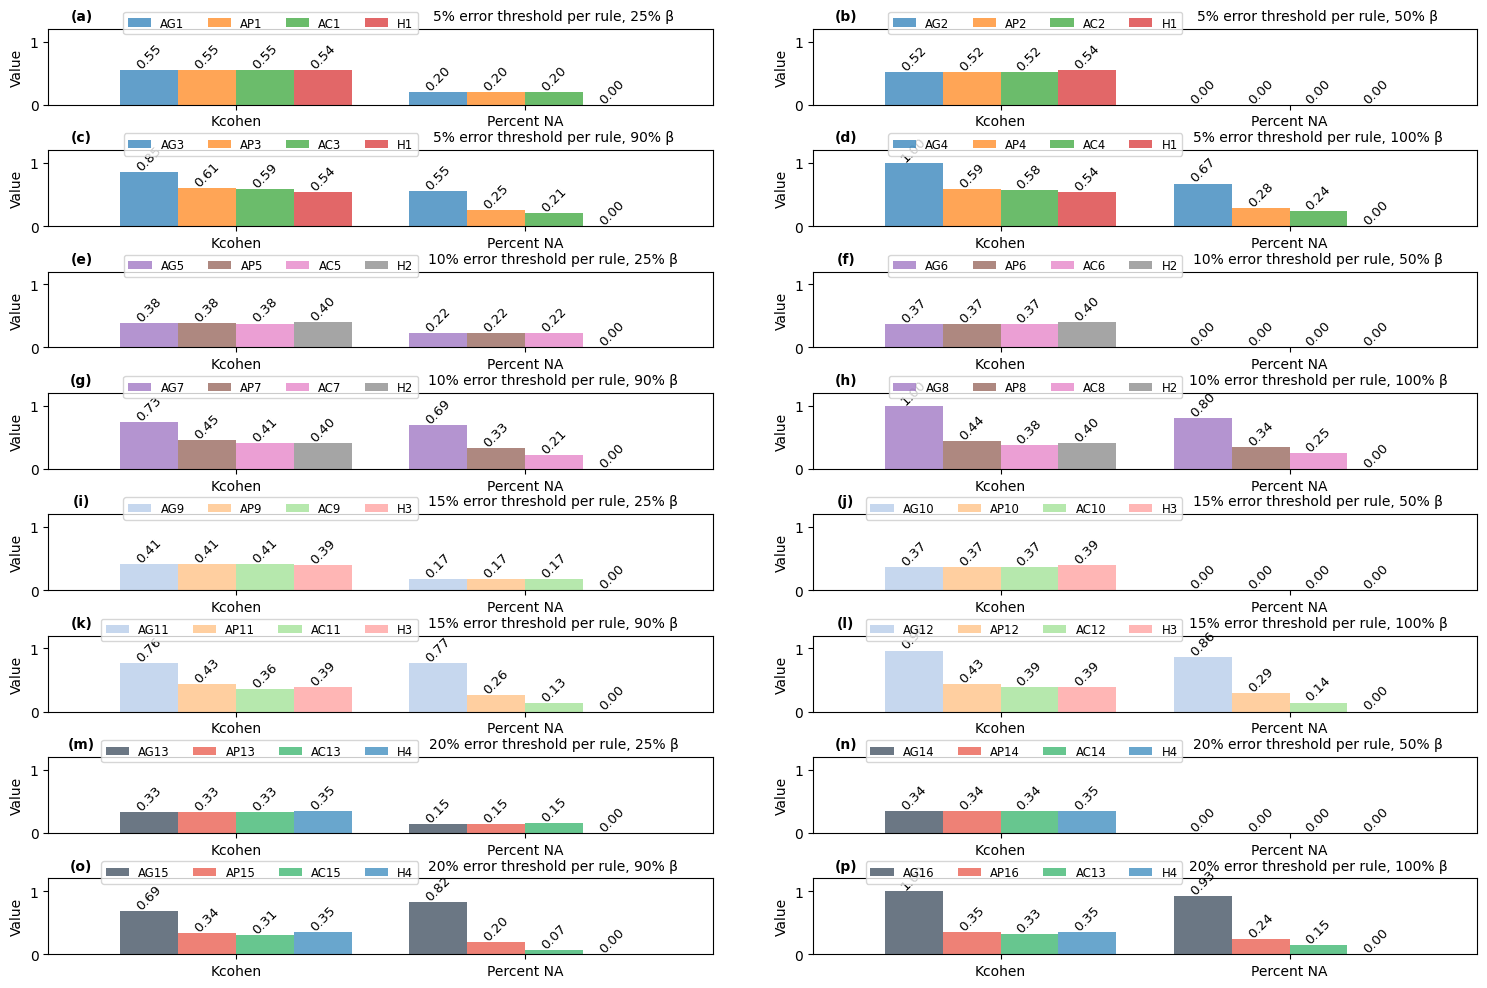

In [38]:
df = results_df

# Define groups
groups = [
    (['AG1', 'AP1', 'AC1', 'H1']),
    (['AG2', 'AP2', 'AC2', 'H1']),
    (['AG3', 'AP3', 'AC3', 'H1']),
    (['AG4', 'AP4', 'AC4', 'H1']),
    (['AG5', 'AP5', 'AC5', 'H2']),
    (['AG6', 'AP6', 'AC6', 'H2']),
    (['AG7', 'AP7', 'AC7', 'H2']),
    (['AG8', 'AP8', 'AC8', 'H2']),
    (['AG9', 'AP9', 'AC9', 'H3']),
    (['AG10', 'AP10', 'AC10', 'H3']),
    (['AG11', 'AP11', 'AC11', 'H3']),
    (['AG12', 'AP12', 'AC12', 'H3']),
    (['AG13', 'AP13', 'AC13', 'H4']),
    (['AG14', 'AP14', 'AC14', 'H4']),
    (['AG15', 'AP15', 'AC15', 'H4']),
    (['AG16', 'AP16', 'AC13', 'H4'])
]

# Create a figure with 16 subplots
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(15, 10))
axes = axes.flatten()

# Define colors for each group
colors_group1 = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
colors_group2 = ['#9467bd', '#8c564b', '#e377c2', '#7f7f7f']
colors_group3 = ['#aec7e8', '#ffbb78', '#98df8a', '#ff9896']
colors_group4 = ['#2c3e50', '#e74c3c', '#27ae60', '#2980b9']

inconsistency_budget = ["25%", "50%", "90%", "100%"] * 4
error_threshold = ["5%"] * 4 + ["10%"] * 4 + ["15%"] * 4 + ["20%"] * 4

label = ["(a)", "(b)", "(c)", "(d)", "(e)", "(f)", "(g)", "(h)", "(i)", "(j)", "(k)", "(l)", "(m)", "(n)", "(o)", "(p)"]

# Plot each group
for i, group in enumerate(groups):
    group_df = df.loc[group]

    # Transpose the dataframe to have metrics as columns and indexes as rows
    group_df = group_df.T

    # Determine colors for the current group
    if i < 4 :
        colors = colors_group1 
    elif i < 8:
        colors = colors_group2
    elif i < 12:
        colors = colors_group3 
    else:
        colors = colors_group4

    # Plot the grouped bar plot
    ax = group_df.plot(kind='bar', ax=axes[i], width=0.8, alpha=0.7, color=colors)
    axes[i].set_ylabel('Value')
    axes[i].set_ylim(0, 1.2)
    axes[i].set_xticklabels(group_df.index, rotation=0, ha='center')

    # Annotate each bar with its height
    for p in axes[i].patches:
        axes[i].annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=9.5, rotation=45)

    # Set legend for the current subplot (horizontal below the plot)
    handles, labels = ax.get_legend_handles_labels()
    axes[i].text(0.05, 1.17, label[i], transform=axes[i].transAxes, fontsize=10, ha='center', va='center', fontweight='bold')

    axes[i].legend(handles, labels, loc='upper right', bbox_to_anchor=(0.565, 1.3), ncol=len(labels), fontsize='small')
    # Add text below the legend
    axes[i].text(0.76, 1.17, error_threshold[i] + " error threshold per rule, " + inconsistency_budget[i] + " β", transform=axes[i].transAxes, fontsize=10, ha='center', va='center')

plt.tight_layout()

# Adjust vertical space between subplots
plt.subplots_adjust(hspace=0.6, wspace=0.15)

# Adjust layout and save the plot
plt.savefig(base + '.png', dpi=300, bbox_inches='tight')
plt.show()
